In [2]:
%load_ext autoreload
%autoreload 2

import os

import sys
sys.path.append(os.environ['GORDON_REPO_DIR'] + '/pipeline_scripts')

from utilities2014 import *

import time

sys.path.append('/home/yuncong/project/opencv-2.4.9/release/lib/python2.7/site-packages')
import cv2

from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import average, fcluster, leaders, complete, single, dendrogram, ward

from joblib import Parallel, delayed

from skimage.color import gray2rgb
from skimage.util import img_as_float, pad
from skimage.morphology import disk
from skimage.filters.rank import gradient

from collections import defaultdict, Counter
from itertools import combinations, chain, product

import networkx
from networkx import from_dict_of_lists, dfs_postorder_nodes

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
from scipy.interpolate import RectBivariateSpline
from skimage.feature import peak_local_max

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
dms = [DataManager(generate_hierarchy=False, stack='RS141', resol='x5', section=i) for i in range(7)]

/oasis/projects/nsf/csd181/yuncong/virtualenv-1.9.1/yuncongve/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


In [349]:
section_ind = 2

dm = dms[section_ind]
dm._load_image()

texton_hists = dm.load_pipeline_result('texHist', 'npy')
segmentation = dm.load_pipeline_result('segmentation', 'npy')
n_superpixels = len(np.unique(segmentation)) - 1
textonmap = dm.load_pipeline_result('texMap', 'npy')
n_texton = len(np.unique(textonmap)) - 1

texture_map = dm.load_pipeline_result('textureMap', 'npy')
Gmax = dm.load_pipeline_result('Gmax', 'npy')

alpha = 1.5
Gmax = 1 - 1/(1+alpha*Gmax)

thetas = np.linspace(-np.pi/4, np.pi/4, 9)
n_theta = len(thetas)
Rs = [np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) for theta in thetas]

grid_spacing = (10,10)

In [350]:
n_sample = 5
r = np.linspace(0,1,n_sample) * 20

In [354]:
# zc = 0

def evaluate_spline_partial(spline, s):
    return spline(s, range(dm.image_height)) # indirect call is faster than directly put spline() in delayed; don't know why

def compute_filter_response_at_points(pts, theta, t2, template_height, template_width, yc, xc):
    
#     global zc

    vs = np.empty((len(pts),), dtype=np.float)
    vs_texture = np.empty((len(pts),), dtype=np.float)
    vs_edge = np.empty((len(pts),), dtype=np.float)

    for i, (x, y) in enumerate(pts):
#         b1 = time.time()
        
        yy = (y + lm_edges_tuple_rotated_versions[theta][:,3] - lm_bbox_dims_rotated_versions[theta][9]).astype(np.int, copy=False)
        xx = (x + lm_edges_tuple_rotated_versions[theta][:,2] - lm_bbox_dims_rotated_versions[theta][8]).astype(np.int, copy=False)

        ymax = y + template_height - 1 - yc
        ymin = y - yc
        xmax = x + template_width - 1 - xc
        xmin = x - xc

        t1 = texture_map[ymin:ymax+1:10, xmin:xmax+1:10].reshape((-1,n_texton))    
#         t1 = texture_map[ymin:ymax+1, xmin:xmax+1].reshape((-1,n_texton))    
        
#         b = time.time()
        chi2_dists = chi2s(t1, t2)
#         print time.time() - b

        # I expect to see RuntimeWarnings in this block
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            S_texture = np.nansum(np.exp(-chi2_dists/.5)) / len(chi2_dists)
            if np.isnan(S_texture):
                S_texture = 0

#         valid_ratio = 1 - np.count_nonzero(np.isnan(chi2_dists)) / float(len(chi2_dists))

#         if np.isnan(avg_texture_dist):
# #             zc += 1
#             avg_texture_dist = 0
            
#         vs[i] = valid_ratio * np.exp(-v/.5)

        
        r = Gmax[yy, xx]
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
#             ys = yy[:,None] + int_texture_sampling_positions[:,:,1]
#             xs = xx[:,None] + int_texture_sampling_positions[:,:,0]
            ys = np.maximum(np.minimum(yy[:,None] + int_texture_sampling_positions[:,:,0], dm.image_height-1), 0)
            xs = np.maximum(np.minimum(xx[:,None] + int_texture_sampling_positions[:,:,1], dm.image_width-1), 0)
#             b = time.time()
#             valid = dm.mask[ys,xs]
#             print valid.shape
            avg_int_texture = np.nanmean(texture_map[ys, xs], axis=1)
#             print '1', time.time()-b

#             b = time.time()
            int_texture_dists = chi2s(lm_edges_textures[:,:n_texton], avg_int_texture)
#             print '2', time.time()-b
            
#             ys = yy[:,None] + ext_texture_sampling_positions[:,:,1]
#             xs = xx[:,None] + ext_texture_sampling_positions[:,:,0]
            ys = np.maximum(np.minimum(yy[:,None] + ext_texture_sampling_positions[:,:,0], dm.image_height-1), 0)
            xs = np.maximum(np.minimum(xx[:,None] + ext_texture_sampling_positions[:,:,1], dm.image_width-1), 0)
            avg_ext_texture = np.nanmean(texture_map[ys, xs], axis=1)
            ext_texture_dists = chi2s(lm_edges_textures[:,n_texton:], avg_ext_texture)
            
#             vs[i] = np.nansum(r * (np.exp(-cs_int/.5) + np.exp(-cs_ext/.5))) + np.exp(-v/.5) #!!NEED MORE SENsible weights

            
            sigma = .5
            S_edge = np.nansum(r * np.exp(-(int_texture_dists+ext_texture_dists)/(2*sigma)))

            vs[i] = S_texture + S_edge
            vs_texture[i] = S_texture
            vs_edge[i] = S_edge

#         print '2', time.time() - b1
    return vs, vs_texture, vs_edge


# def find_lm(lm_ind):
    
lm_ind = 1

print 'landmark', lm_ind

global lm_edges_tuple_rotated_versions
global lm_bbox_dims_rotated_versions
global lm_texture_template_rotated_versions
global lm_edges_textures

lm_texture_template_rotated_versions = [np.load('/home/yuncong/csd395/lm_texture_template_%d_orientation%d.npy'%(lm_ind, theta_i)) 
                                        for theta_i in range(n_theta)]
lm_bbox_dims_rotated_versions = [np.load('/home/yuncong/csd395/lm_bbox_dims_%d_orientation%d.npy'%(lm_ind, theta_i)) 
                                        for theta_i in range(n_theta)]
lm_edges_tuple_rotated_versions = [np.load('/home/yuncong/csd395/lm_edge_points_%d_orientation%d.npy'%(lm_ind, theta_i)) 
                                        for theta_i in range(n_theta)]
lm_edges_textures = np.load('/home/yuncong/csd395/lm_edge_textures_%d.npy'%(lm_ind))

global ext_texture_sampling_positions
global int_texture_sampling_positions

#=============================================================

vs_max = np.zeros((dm.image_height, dm.image_width))
vs_argmax = np.zeros((dm.image_height, dm.image_width), np.uint8)

vs_max_all_angles = []
v_texture_all_angles = []
v_edge_all_angles = []

# theta = 4

for theta in range(n_theta):

    print 'theta', theta

    b = time.time()

    ext_texture_sampling_positions = (lm_edges_tuple_rotated_versions[theta][:,4:][:, None, ::-1] * r[None,:,None]).astype(np.int)
    int_texture_sampling_positions = - ext_texture_sampling_positions

    template_width, template_height = lm_bbox_dims_rotated_versions[theta][:2]
    xc, yc = lm_bbox_dims_rotated_versions[theta][8:10]

    ys, xs = np.mgrid[yc : dm.image_height + yc - template_height : grid_spacing[0], 
                      xc : dm.image_width + xc - template_width : grid_spacing[1]]

    t2 = lm_texture_template_rotated_versions[theta][::10,::10].reshape((-1,n_texton))  
    # t2 = lm_texture_template_rotated_versions[theta].reshape((-1,n_texton))  

    res =  Parallel(n_jobs=16)(delayed(compute_filter_response_at_points)(s, theta,
                                    t2, template_height, template_width, yc, xc) 
                            for s in np.array_split(zip(xs.flat, ys.flat), 16))
    
    V, Vtexture, Vedge = zip(*res)

    # V = []
    # for s in np.array_split(zip(xs.flat, ys.flat), 16):
    # #         q = time.time()
    #     V.append(compute_filter_response_at_points(s, theta, t2, template_height, template_width, yc, xc))
    # #         print time.time() - q

    vss = np.reshape(np.concatenate(V), xs.shape)
    vs_texture = np.reshape(np.concatenate(Vtexture), xs.shape)
    vs_edge = np.reshape(np.concatenate(Vedge), xs.shape)

    spline = RectBivariateSpline(range(xc, dm.image_width + xc - template_width, grid_spacing[1]), 
                                 range(yc, dm.image_height + yc - template_height, grid_spacing[0]),
                                 vss.T, bbox=[0, dm.image_width-1, 0, dm.image_height-1])

    xmax = xs.max()
    ymax = ys.max()
    xmin = xs.min()
    ymin = ys.min()

    res = Parallel(n_jobs=16)(delayed(evaluate_spline_partial)(spline, s) 
                              for s in np.array_split(range(dm.image_width), 16))
    vs_i = np.vstack(res).T
    vs_i[~dm.mask] = 0.
    vs_i[ymax+1:dm.image_height] = 0.
    vs_i[:ymin] = 0.
    vs_i[:, xmax+1:dm.image_width] = 0.
    vs_i[:, :xmin] = 0.

    vs_max_all_angles.append(vs_i)
    v_texture_all_angles.append(vs_texture)
    v_edge_all_angles.append(vs_edge)
    
    #         dm.save_pipeline_result(vs_i, 'responseMapLm%dTheta%d'%(lm_ind, theta), 'npy')

    print time.time() - b

    #################

top3_locs = []
for theta, vs_max in enumerate(vs_max_all_angles):
    vs_max_smooth = gaussian_filter(vs_max, sigma=10)

    peaks = peak_local_max(vs_max_smooth)
    ypeaks = peaks[:,0]
    xpeaks = peaks[:,1]

    order = np.argsort(vs_max_smooth[ypeaks, xpeaks])[::-1]
    ypeaks = ypeaks[order]
    xpeaks = xpeaks[order]

    for y, x in zip(ypeaks, xpeaks)[:3]:
        top3_locs.append((y, x, vs_max[y, x], theta))

top3_locs = sorted(top3_locs, key=lambda x: x[2], reverse=True)[:3]

# dm.save_pipeline_result(np.array(top3_locs), 'responsePeaksLm%d'%lm_ind, 'npy')

landmark 1
theta 0
9.62865018845
theta 1
9.20373702049
theta 2
9.40911102295
theta 3
9.79320788383
theta 4
9.73791599274
theta 5
10.2488589287
theta 6
10.189606905
theta 7
10.206856966
theta 8
9.59676980972


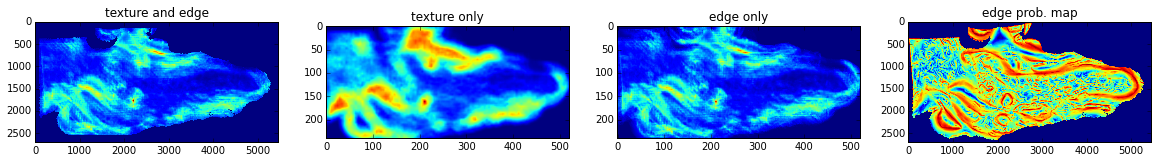

In [352]:
fig, axes = plt.subplots(1,4, figsize=(20,20))
axes[0].imshow(vs_max_all_angles[4]);
axes[0].set_title('texture and edge');
axes[1].imshow(v_texture_all_angles[4]);
axes[1].set_title('texture only');
axes[2].imshow(v_edge_all_angles[4]);
axes[2].set_title('edge only');
axes[3].imshow(Gmax);
axes[3].set_title('edge prob. map');

In [12]:
find_lm(2)

landmark 2
theta 0
1.14696979523
theta 1
1.18022203445
theta 2
1.1065030098
theta 3
1.09699201584
theta 4
1.14134979248
theta 5
1.24552178383
theta 6
1.28649401665
theta 7
1.37010407448
theta 8
1.17527794838
saved /oasis/projects/nsf/csd395/yuncong/DavidData2014results/RS141/0002/RS141_x5_0002_gabor-blueNisslWide-segm-blueNisslRegular-vq-blueNissl_responsePeaksLm2.npy


In [348]:
top3_locs

[(1768, 2195, 9.8705409099983648, 4),
 (1779, 2212, 8.1615412100388109, 3),
 (730, 2825, 8.0985231018020531, 4)]

In [6]:
section_ind = 3
locs = [np.load('/home/yuncong/csd395/top3LocsLm%dSect%d.npy'%(lm_ind, section_ind)) for lm_ind in range(6)]

In [7]:
centroids = []
for lm_ind in range(6):
    segment_points = np.load('/home/yuncong/csd395/sample_landmark_%d.npy'%lm_ind)
    centroid = np.mean(segment_points[:, [1,0]], axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)

In [8]:
def rigid_transform_from_pairs(X,Y):
    '''
    X, Y are n-by-2 matrices
    Y = RX
    '''
    
    Xcentroid = X.mean(axis=0)
    Ycentroid = Y.mean(axis=0)
    
    Xcentered = X - Xcentroid
    Ycentered = Y - Ycentroid
    
    U, S, V = np.linalg.svd(np.dot(Xcentered.T, Ycentered))
    M = [[1, 0], [0, np.linalg.det(np.dot(V, U.T))]]
    R = np.dot(V, np.dot(M, U.T))
    angle = np.arctan2(R[1,0], R[0,0])
    t = Ycentroid.T - np.dot(R, Xcentroid.T)
    
    T = np.eye(3)
    T[:2, :2] = R
    T[:2, 2] = t
   
    return T, angle

def rigid_transform_to(pts1, T):
    pts1_trans = np.dot(T, np.column_stack([pts1, np.ones((pts1.shape[0],))]).T).T
    pts1_trans = pts1_trans[:,:2]/pts1_trans[:,-1][:,np.newaxis]
    return pts1_trans


In [9]:
n_inliers = []
rewards = []
Ts = []
As = []
all_matches = []
for ransac_i in range(100):

    lm_samples = np.random.randint(0,6,3)
    samples = np.array([np.r_[locs[l][np.random.randint(0,3), :2], centroids[l]] for l in lm_samples]).astype(np.int)
    T, a = rigid_transform_from_pairs(samples[:,:2], samples[:,2:])

    n_inlier = 0
    reward = 0
    pairs = []
    matches = []
    for l in range(6):
        vecs = rigid_transform_to(locs[l][:,:2], T) - centroids[l]
        ds = np.sqrt(np.sum(vecs**2, axis=1))
        nn = ds.argmin()
        if ds[nn] < 300:
            n_inlier += 1
            reward += np.exp(-ds[nn]/400.)  # !!! use response map to evaluate goodness
            matches.append((l,nn))
            pairs.append(np.r_[locs[l][nn,:2], centroids[l]])
            
            
    n_inliers.append(n_inlier)
    rewards.append(reward)
    
    if len(pairs) > 0:            
        pairs = np.array(pairs)
        T, a = rigid_transform_from_pairs(pairs[:,:2], pairs[:,2:])
        Ts.append(T)
        As.append(a)
        all_matches.append(matches)
    else:
        Ts.append(None)
        As.append(None)
        all_matches.append(None)
        
best_iter = np.argmax(rewards)

print n_inliers[best_iter]
print rewards[best_iter]
print all_matches[best_iter]

5
4.27425426197
[(0, 0), (1, 0), (2, 0), (3, 1), (5, 1)]


In [10]:
np.abs(As[best_iter] - thetas).argmin()

4

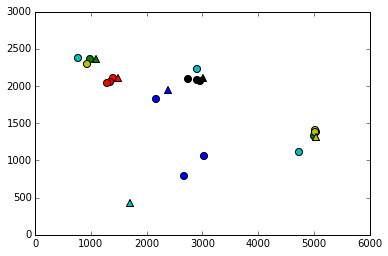

In [11]:
colors = 'rgbkcy'
for l in range(6):
    plt.scatter(locs[l][:,1], locs[l][:,0], c=colors[l], s=50);
    plt.scatter(centroids[l, 1], centroids[l, 0], marker='^', c=colors[l], s=50);
    
plt.show()

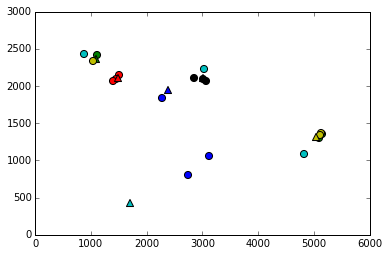

In [12]:
colors = 'rgbkcy'
for l in range(6):
    tr = rigid_transform_to(locs[l][:,:2], Ts[best_iter])
    plt.scatter(tr[:,1], tr[:,0], c=colors[l], s=50);
    plt.scatter(centroids[l, 1], centroids[l, 0], marker='^', c=colors[l], s=50);
    
plt.show()

In [184]:
# n_texton = 14

# for lm_ind in range(6):

#     segment_points = np.load('/home/yuncong/csd395/sample_landmark_2.npy')

#     sample_segment_int_texture = segment_points[:, 2:2+n_texton]
#     sample_segment_ext_texture = segment_points[:, 2+n_texton:-2]

#     sample_segment_vector = segment_points[:, -2:]

#     template_points_rotated_versions = []

#     centroid = np.mean(segment_points[:, [1,0]], axis=0)
#     segment_points_centered = segment_points[:, [1,0]] - centroid

#     thetas = np.linspace(-np.pi/4, np.pi/4, 9)
#     n_theta = len(thetas)

#     for theta in thetas:
#         R = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
#         sample_segment_pts = np.dot(R, segment_points_centered.T).astype(np.int).T
#         shifted_sample_segment_pts = sample_segment_pts - sample_segment_pts.min(axis=0)

#         template_points_rotated_versions.append(shifted_sample_segment_pts)

#     template_shape_rotated_versions = [pts.max(axis=0) + [1,1] for pts in template_points_rotated_versions]

#     # # visualize the templates

#     # for i in range(len(thetas)):

#     #     template_points = template_points_rotated_versions[i]

#     #     template = np.zeros(template_shape_rotated_versions[i], np.bool)
#     #     template[template_points[:,0], template_points[:,1]] = 1
#     #     plt.figure()
#     #     plt.title('rotated %d' % i)
#     #     plt.imshow(template, cmap=plt.cm.gray_r)

#     n_sample = 5
#     r = np.linspace(0,1,n_sample) * 20
#     ext_texture_sampling_positions = (sample_segment_vector[:, None, ::-1] * r[None,:,None]).astype(np.int)
#     int_texture_sampling_positions = (sample_segment_vector[:, None, ::-1] * -r[None,:,None]).astype(np.int)

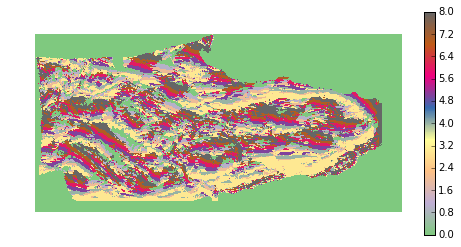

In [511]:
plt.matshow(vs_argmax, cmap=plt.cm.Accent);
plt.colorbar();
plt.axis('off');

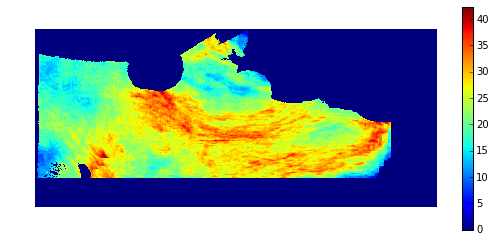

In [547]:
plt.matshow(vs_max);
plt.colorbar();
plt.axis('off');

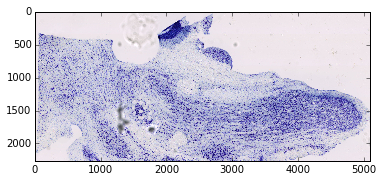

In [548]:
plt.imshow(dm.image_rgb);

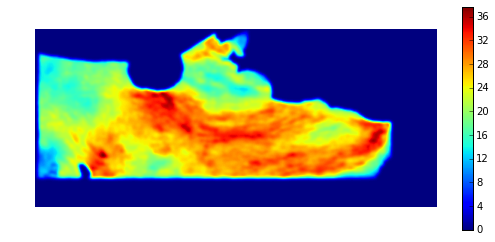

In [549]:
vs_max_smooth = gaussian_filter(vs_max, sigma=20)

plt.matshow(vs_max_smooth);
plt.colorbar();
plt.axis('off');

In [510]:
from skimage.feature import peak_local_max

peaks = peak_local_max(vs_max_smooth)
ypeaks = peaks[:,0]
xpeaks = peaks[:,1]

order = np.argsort(vs_max_smooth[ypeaks, xpeaks])[::-1]
ypeaks = ypeaks[order]
xpeaks = xpeaks[order]


bg_ubyte = img_as_ubyte(dm.image_rgb)

for i, (ybest, xbest) in enumerate(zip(ypeaks, xpeaks)[:10]):

    best_theta = vs_argmax[ybest, xbest]
    
    print ybest, xbest, vs_max[ybest, xbest], best_theta

    shifted_ys_best = ybest + template_points_rotated_versions[best_theta][:,0]
    shifted_xs_best = xbest + template_points_rotated_versions[best_theta][:,1]
    
    overlay = np.zeros_like(dm.image, np.bool)
    overlay[shifted_ys_best, shifted_xs_best] = 1
    overlay = binary_dilation(overlay, disk(5))
    bg_ubyte[overlay] = [0,255,0]

    cv2.putText(bg_ubyte, str(i), (xbest, ybest), 
                cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 3, ((255,0,255)), 10)

display(bg_ubyte)

514 2433 11.5746129553 2
814 3399 12.2974272071 1
1992 2846 10.3782295458 1
2039 2794 11.0575632701 2
2025 2574 11.0158276602 5
1951 2542 10.6097395553 6
412 1368 11.4753195648 1
605 2727 9.83488939297 7
384 1623 10.011322959 8
657 2799 10.1610495041 7


/oasis/projects/nsf/csd395/yuncong/Brain/notebooks/tmp.jpg

In [ ]:
# def ransac_matching(matches):
        
#     import networkx as nx
    
#     n_boundaries1, n_boundaries2 = D_boundaries.shape
    
#     nn1 = D_boundaries.argsort(axis=1)
#     dd1 = np.sort(D_boundaries,axis=1)
#     nn1 = [nn[:np.searchsorted(d, d[0]+0.2)] for d, nn in zip(dd1, nn1)]
    
#     nn2 = D_boundaries.argsort(axis=0).T
#     dd2 = np.sort(D_boundaries,axis=0).T
#     nn2 = [nn[:np.searchsorted(d, d[0]+0.2)] for d, nn in zip(dd2, nn2)]

#     DD = np.zeros((n_boundaries1+n_boundaries2, n_boundaries1+n_boundaries2))
#     G = nx.Graph(DD)
#     G = nx.relabel_nodes(G, dict([(i,(0,i)) for i in range(n_boundaries1)]+[(n_boundaries1+j,(1,j)) for j in range(n_boundaries2)]))
#     matches = []
#     for i in range(n_boundaries1):
#         for j in range(n_boundaries2):
# #             if j in nn1[i,:k] and i in nn2[j,:k]:
#             if j in nn1[i] and i in nn2[j]:
#                 matches.append((i,j))
#                 G.add_edge((0,i), (1,j))

#     ms = [sorted(g) for g in sorted(list(nx.connected_components(G)), key=len, reverse=True) if len(g) >= 2]
        
#     groups = []
#     for mi, m in enumerate(ms):
#         d = defaultdict(list)
#         for sec_i, bnd_i in m:
#             d[sec_i].append(bnd_i)
#         A = D_boundaries[d[0]][:,d[1]]
#         rs, cs = np.unravel_index(np.argsort(D_boundaries[d[0]][:,d[1]].flat), (len(d[0]), len(d[1])))
#     #     print rs, cs
#     #     print [((sec1, d[sec1][r]), (sec2, d[sec2][c]), D_boundaries[d[sec1][r], d[sec2][c]]) for r, c in zip(rs, cs)
#     #           if D_boundaries[d[sec1][r], d[sec2][c]] < np.inf]

#         g = []
#         for r, c in zip(rs, cs):
#             if D_boundaries[d[0][r], d[1][c]] < np.inf:
#     #             print ((sec1, d[sec1][r]), (sec2, d[sec2][c]), D_boundaries[d[sec1][r], d[sec2][c]])
#                 g.append([d[0][r], d[1][c]])

#         groups.append(g)
    
# #     print groups
    
#     # RANSAC
#     import random

#     boundary1_centers = np.array([b[4][::-1] for b in boundaries1])
#     boundary2_centers = np.array([b[4][::-1] for b in boundaries2])

#     matches = []
#     scores = []

#     for ransac_iter in range(100):

#         boundary_samples = [random.sample(g, 1)[0] for g in random.sample(groups, min(len(groups), 3))]
#         X = []
#         Y = []
#         for b1, b2 in boundary_samples:
#             X.append(boundary1_centers[b1])
#             Y.append(boundary2_centers[b2])
#         X = np.array(X)
#         Y = np.array(Y)

#         T, angle = rigid_transform_from_pairs(X,Y)
#     #     print T, angle
#         if angle > np.pi/2:
#     #         print 'angle too wide'
#             matches.append([])
#             scores.append(0)
#             continue

#         boundary1_centers_trans = rigid_transform_to(boundary1_centers, T)
# #         print np.linalg.norm(boundary1_centers_trans[10]-boundary2_centers[4])

#         match = [(bi,bj) for g in groups for bi,bj in g 
#                  if np.linalg.norm(boundary1_centers_trans[bi] - boundary2_centers[bj]) < centroid_dist_limit]

#         score = len(match)

#         matches.append(match)
#         scores.append(score)

#     best = np.argmax(scores)
#     s_best = scores[best]
#     m_best = matches[best]
# #     print m_best

#     g = nx.Graph()
#     g.add_edges_from([((0, i),(1, j), {'weight': D_boundaries[D_boundaries!=np.inf].max()-D_boundaries[i,j]}) 
#                       for i,j in m_best])
#     m = nx.matching.max_weight_matching(g, maxcardinality=True)
    
#     best_match = set(((0, dict([n1,n2])[0]), (1, dict([n1,n2])[1])) for n1,n2 in m.iteritems())
    
#     print len(best_match)
    
#     return best_match